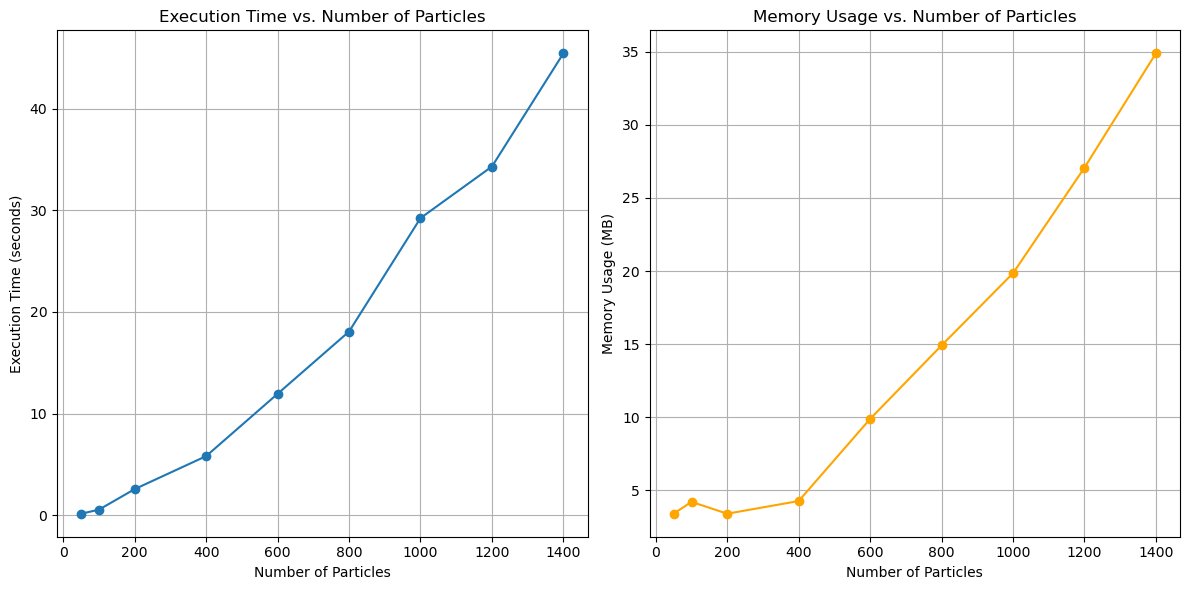

In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
import psutil
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import itertools
import copy
import cProfile
from scipy.sparse import lil_matrix

# Define a function to generate the Hamiltonian
def generate_hamiltonian(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = copy.copy(event.modules)
    modules.sort(key=lambda a: a.z)

    segments = (
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit in modules[idx].hits
        for to_hit in modules[idx + 1].hits
    )
    segment_vectors = (seg.to_vect() for seg in segments)

    N = sum(1 for _ in segment_vectors)
    A_ang = lil_matrix((N, N), dtype=np.float32)
    A_bif = lil_matrix((N, N), dtype=np.float32)
    A_inh = lil_matrix((N, N), dtype=np.float32)

    s_ab = (
        int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
        for seg_i, seg_j in itertools.product(segments, repeat=2)
    )

    norm_cache = {}

    def get_vector_and_norm(seg, idx):
        if idx not in norm_cache:
            vect = seg.to_vect()
            norm_cache[idx] = (vect, np.linalg.norm(vect))
        return norm_cache[idx]

    for i, seg_i in enumerate(segments):
        vect_i, norm_i = get_vector_and_norm(seg_i, i)

        for j in range(i + 1, N):
            seg_j = segments[j]
            vect_j, norm_j = get_vector_and_norm(seg_j, j)

            cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)

            eps = 1e-9
            if np.abs(cosine - 1) < eps:
                A_ang[i, j] = A_ang[j, i] = 1

            if (seg_i.from_hit == seg_j.from_hit) and (seg_i.to_hit != seg_j.to_hit):
                A_bif[i, j] = A_bif[j, i] = -alpha

            if (seg_i.from_hit != seg_j.from_hit) and (seg_i.to_hit == seg_j.to_hit):
                A_bif[i, j] = A_bif[j, i] = -alpha

            A_inh[i, j] = A_inh[j, i] = s_ab[i * N + j] * s_ab[j * N + i] * beta

    A = -1 * (A_ang + A_bif + A_inh).tocsc()
    b = np.zeros(N, dtype=np.float32)

    components = {
        'A_ang': -A_ang,
        'A_bif': -A_bif,
        'A_inh': -A_inh,
    }

    return A, b, components, segments

# Initialize the detector geometry
N_MODULES = 5
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX]*N_MODULES,
    ly=[LY]*N_MODULES,
    z=[i+Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi/6
)

params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,
}

# Define a function to measure execution time and memory usage
def measure_performance(n_particles, generator, params):
    event = generator.generate_event(n_particles)

    process = psutil.Process()
    start_time = time.time()
    mem_start = process.memory_info().rss / (1024 ** 2)

    A, b, _, _ = generate_hamiltonian(event, params)

    finish_time = time.time()
    mem_end = process.memory_info().rss / (1024 ** 2)

    exec_time = finish_time - start_time
    mem_usage = mem_end - mem_start

    return exec_time, mem_usage

# Test different numbers of particles and record performance
particle_counts = [50, 100, 200, 400, 600, 800, 1000, 1200, 1400]
execution_times = []
memory_usages = []

for n_particles in particle_counts:
    exec_time, mem_usage = measure_performance(n_particles, generator, params)
    execution_times.append(exec_time)
    memory_usages.append(mem_usage)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(particle_counts, execution_times, marker='o')
plt.title('Execution Time vs. Number of Particles')
plt.xlabel('Number of Particles')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(particle_counts, memory_usages, marker='o', color='orange')
plt.title('Memory Usage vs. Number of Particles')
plt.xlabel('Number of Particles')
plt.ylabel('Memory Usage (MB)')
plt.grid(True)

plt.tight_layout()
plt.show()
